<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/). 

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.9.1+cu128
torchvision version: 0.24.1+cu128


In [5]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [7]:
# # Download pizza, steak, sushi images from GitHub
# image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
#                            destination="pizza_steak_sushi")
from pathlib import Path
image_path = Path.cwd().parent.parent / 'data'/ 'pizza_steak_sushi'

In [8]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [9]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [10]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x24fa2066900>,
 ['pizza', 'steak', 'sushi'])

In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

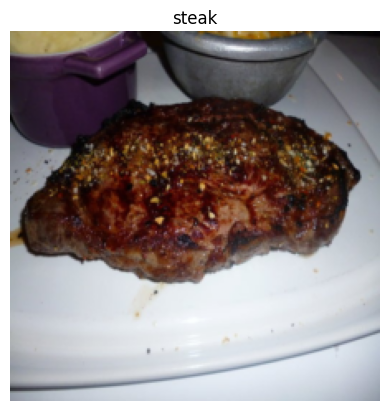

In [14]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks). 
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [63]:
# TODO: your code
class PatchEmbeddingEncoder(torch.nn.Module):
    def __init__(self, 
                 H : int,
                 W : int,
                 patch_size : int,
                 in_channels : int = 3,
                 D : int = 768,
                 ):
        if any([H % patch_size, W % patch_size]):
            raise ValueError('Height and wdith must be divisble by the patch_size')

        super().__init__()
        num_patches = (H * W ) // (patch_size ** 2)
        self._conv2d = torch.nn.Conv2d(in_channels=in_channels, 
                                       out_channels=D,
                                       kernel_size=patch_size,
                                       stride=patch_size, 
                                       padding=0)
        self._Flatten = torch.nn.Flatten(start_dim=2, end_dim=3)
        self._class_embed = torch.nn.Parameter(torch.randn(size=[1, 1, D]))
        self._position_embed = torch.nn.Parameter(torch.randn(size=[num_patches+1, D]))
    def forward(self, x : torch.Tensor):
        x = self._conv2d(x)
        x = self._Flatten(x)
        x = x.permute(0,2,1)
        class_embed = self._class_embed.expand(x.shape[0], -1, -1)
        x = torch.cat([class_embed, x], dim=1)
        x = x + self._position_embed
        return x
    
    

class Vit(torch.nn.Module):
    def __init__(self, 
                 num_cls : int,
                 H : int = 224,
                 W : int = 224,
                 patch_size : int = 16,
                 in_channels : int = 3,
                 D : int = 768,
                 num_heads : int = 12,
                 num_transformer_layers : int = 12,
                 embed_dropout : float = 0.1,
                 mlp_hidden : int = 3072
                 ):
        super().__init__()
        self._EmbeddingEncoder = PatchEmbeddingEncoder(
            H=H, W=W, patch_size=patch_size, in_channels=in_channels, D=D
        )
        self._embedDropout = torch.nn.Dropout(embed_dropout)
        transformer_encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=D,
            nhead=num_heads,
            batch_first=True,
            norm_first=True,
            activation=torch.nn.functional.gelu,
            dim_feedforward=mlp_hidden
        )
        self._transformerEncoder = torch.nn.TransformerEncoder(
            encoder_layer=transformer_encoder_layer,
            num_layers=num_transformer_layers,
            )
        
        self._classifier = torch.nn.Sequential(
            torch.nn.LayerNorm(D),
            torch.nn.Linear(in_features=D, out_features=num_cls)
        )

    def forward(self, x):
        x = self._transformerEncoder(self._embedDropout(self._EmbeddingEncoder(x)))
        return self._classifier(x[:,0])
    

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/). 


In [64]:
num_class = len(train_dataloader.dataset.classes)

Vit0 = Vit(num_cls=num_class)
Vit0.to(device)
sample = torch.rand(size = [32, 3, 224, 224])

# Vit0(sample)

summary(model=Vit0,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)



d:\miniconda\envs\torch\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
Vit (Vit)                                               [32, 3, 224, 224]    [32, 3]              --                   True
├─PatchEmbeddingEncoder (_EmbeddingEncoder)             [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    └─Conv2d (_conv2d)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (_Flatten)                               [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (_embedDropout)                               [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (_transformerEncoder)              [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets) 
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [66]:
# TODO: your code
import math
import tqdm.auto as tqdm

EPOCH = 5
loss_fn = torch.nn.CrossEntropyLoss()

def create_lr_scheduler(optim, warmup_steps, total_steps):
    """Create a learning rate scheduler with warmup and cosine annealing decay."""
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps  # Linear warmup from 0 to 1
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1.0 + math.cos(math.pi * progress))  # Cosine annealing
    
    return torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda)


# Calculate scheduler parameters
# Note: scheduler.step() is called once per epoch, not per batch
total_steps = EPOCH  # Total number of epochs (5)
warmup_steps = max(1, int(0.1 * total_steps))  # 10% of epochs for warmup (0.5 → 1 epoch min)
base_lr = 1e-3

# Create optimizer and scheduler
optim = torch.optim.Adam(Vit0.parameters(), lr=base_lr)
scheduler = create_lr_scheduler(optim, warmup_steps=warmup_steps, total_steps=total_steps)

print(f"Total steps (epochs): {total_steps}")
print(f"Warmup steps (epochs): {warmup_steps}")

# Training loop
results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

for epoch in tqdm.trange(EPOCH, desc="Epochs"):
    # Train step
    train_loss, train_acc = engine.train_step(
        model=Vit0, 
        dataloader=train_dataloader,
        loss_fn=loss_fn, 
        optimizer=optim,
        device=device
    )
    
    # Test step
    test_loss, test_acc = engine.test_step(
        model=Vit0,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=device
    )
    
    # Step scheduler after each epoch
    scheduler.step()
    
    # Store results
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    
    print(f"Epoch {epoch+1}/{EPOCH} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% | LR: {optim.param_groups[0]['lr']:.2e}")

Total steps (epochs): 5
Warmup steps (epochs): 1


Epochs:  20%|██        | 1/5 [00:17<01:08, 17.05s/it]

Epoch 1/5 | Train Loss: 1.0726, Train Acc: 0.43% | Test Loss: 1.1449, Test Acc: 0.26% | LR: 1.00e-03


Epochs:  40%|████      | 2/5 [00:29<00:42, 14.32s/it]

Epoch 2/5 | Train Loss: 2.4742, Train Acc: 0.41% | Test Loss: 2.6149, Test Acc: 0.26% | LR: 8.54e-04


Epochs:  60%|██████    | 3/5 [00:41<00:26, 13.44s/it]

Epoch 3/5 | Train Loss: 1.6113, Train Acc: 0.38% | Test Loss: 1.2409, Test Acc: 0.54% | LR: 5.00e-04


Epochs:  80%|████████  | 4/5 [00:54<00:13, 13.04s/it]

Epoch 4/5 | Train Loss: 1.4193, Train Acc: 0.27% | Test Loss: 1.1415, Test Acc: 0.20% | LR: 1.46e-04


Epochs: 100%|██████████| 5/5 [01:06<00:00, 13.33s/it]

Epoch 5/5 | Train Loss: 1.0879, Train Acc: 0.34% | Test Loss: 1.0974, Test Acc: 0.26% | LR: 0.00e+00


## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [14]:
# TODO: your code

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. 
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining** 
    * **Learning rate warmup** 
    * **Learning rate decay** 
    * **Gradient clipping** 

In [15]:
# TODO: your explanations of the above terms